<a href='https://www.kaggle.com/fatmakursun/pyspark-ml-tutorial-for-beginners'>Kaggle 튜토리얼 출처</a>

In [44]:
import os
import pandas as pd
import numpy as np

# pyspark for objecy, sql
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

# pyspark for ML
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
# Setting for visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid',
       rc={'figure.figsize': (18, 4)})
rcParams['figure.figsize'] = 18, 4

In [47]:
# 노트북 재실행을 대비하기 위해 랜덤 시드 설정해놓기
rnd_seed = 23
np.random.seed = rnd_seed
np.random.set_state = rnd_seed

### Creating Spark Session

In [48]:
spark = SparkSession.builder.master('local[2]')\
        .appName('Linear-Regression-California-Housing')\
        .getOrCreate()

In [49]:
spark

In [50]:
# SparkContext 객체와 SQLContext 객체 생성
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=PySparkShell>

In [51]:
# SQLContext는 sparkContext를 집어넣어주자
sqlContext = SQLContext(spark.sparkContext)
sqlContext

### Load file and convert it into DataFrame

In [52]:
data_path = '/Users/younghun/Desktop/gitrepo/data/cal_housing.data'

In [53]:
# data의 칼럼명을 스키마로 정의해주기
schema_string = 'long lat medage totrooms totbdrms pop houshlds medinc medhv'

fields = [StructField(field, FloatType(), True)for field in schema_string.split()]
schema = StructType(fields)
schema

StructType(List(StructField(long,FloatType,true),StructField(lat,FloatType,true),StructField(medage,FloatType,true),StructField(totrooms,FloatType,true),StructField(totbdrms,FloatType,true),StructField(pop,FloatType,true),StructField(houshlds,FloatType,true),StructField(medinc,FloatType,true),StructField(medhv,FloatType,true)))

In [54]:
# 데이터파일 로드
# cache 메소드를 이용해서 메모리에 keep해놓기
housing_df = spark.read.csv(path=data_path, schema=schema).cache()

# 상위 5개 행 미리 보기 -> 하나의 Row가 namedTuple 형태로 되어 있음..!
housing_df.take(5)

[Row(long=-122.2300033569336, lat=37.880001068115234, medage=41.0, totrooms=880.0, totbdrms=129.0, pop=322.0, houshlds=126.0, medinc=8.325200080871582, medhv=452600.0),
 Row(long=-122.22000122070312, lat=37.86000061035156, medage=21.0, totrooms=7099.0, totbdrms=1106.0, pop=2401.0, houshlds=1138.0, medinc=8.301400184631348, medhv=358500.0),
 Row(long=-122.23999786376953, lat=37.849998474121094, medage=52.0, totrooms=1467.0, totbdrms=190.0, pop=496.0, houshlds=177.0, medinc=7.257400035858154, medhv=352100.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1274.0, totbdrms=235.0, pop=558.0, houshlds=219.0, medinc=5.643099784851074, medhv=341300.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1627.0, totbdrms=280.0, pop=565.0, houshlds=259.0, medinc=3.8461999893188477, medhv=342200.0)]

In [55]:
# 로드한 데이터프레임 형태 미리보기
housing_df.show(6)

+-------+-----+------+--------+--------+------+--------+------+--------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|   medhv|
+-------+-----+------+--------+--------+------+--------+------+--------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|452600.0|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|358500.0|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|352100.0|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|341300.0|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|342200.0|
|-122.25|37.85|  52.0|   919.0|   213.0| 413.0|   193.0|4.0368|269700.0|
+-------+-----+------+--------+--------+------+--------+------+--------+
only showing top 6 rows



In [56]:
# 칼럼들 보기
print(housing_df.columns,'\n',type(housing_df.columns))

['long', 'lat', 'medage', 'totrooms', 'totbdrms', 'pop', 'houshlds', 'medinc', 'medhv'] 
 <class 'list'>


In [57]:
# 데이터프레임의 schema 보기
housing_df.printSchema()

root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- medage: float (nullable = true)
 |-- totrooms: float (nullable = true)
 |-- totbdrms: float (nullable = true)
 |-- pop: float (nullable = true)
 |-- houshlds: float (nullable = true)
 |-- medinc: float (nullable = true)
 |-- medhv: float (nullable = true)



### Data Exploration

In [58]:
# 특정 칼럼값들만 추출하기 -> select메소드 이용
housing_df.select('pop', 'medinc').show()

+------+------+
|   pop|medinc|
+------+------+
| 322.0|8.3252|
|2401.0|8.3014|
| 496.0|7.2574|
| 558.0|5.6431|
| 565.0|3.8462|
| 413.0|4.0368|
|1094.0|3.6591|
|1157.0|  3.12|
|1206.0|2.0804|
|1551.0|3.6912|
| 910.0|3.2031|
|1504.0|3.2705|
|1098.0| 3.075|
| 345.0|2.6736|
|1212.0|1.9167|
| 697.0| 2.125|
| 793.0| 2.775|
| 648.0|2.1202|
| 990.0|1.9911|
| 690.0|2.6033|
+------+------+
only showing top 20 rows



In [59]:
# 그룹핑해서 집계해보기
result_df = housing_df.groupBy('medage').count()
result_df.show(5)

+------+-----+
|medage|count|
+------+-----+
|  18.0|  570|
|  47.0|  198|
|   9.0|  205|
|  39.0|  369|
|   5.0|  244|
+------+-----+
only showing top 5 rows



In [60]:
# 값 정렬 기준 설정해주고 내림차순으로 정렬
result_df.sort('medage', ascending=False).show(5)

+------+-----+
|medage|count|
+------+-----+
|  52.0| 1273|
|  51.0|   48|
|  50.0|  136|
|  49.0|  134|
|  48.0|  177|
+------+-----+
only showing top 5 rows



<AxesSubplot:xlabel='medage'>

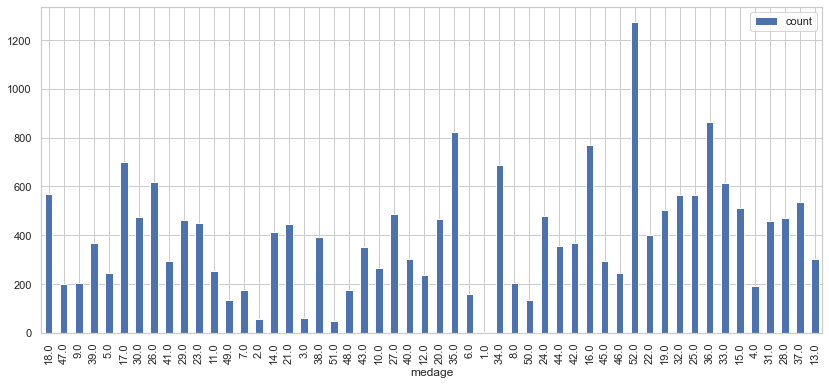

In [61]:
# Bar graph 그리기
# toPandas() 이용
result_df.toPandas().plot.bar(x='medage', figsize=(14, 6))

- Summary Statistics
    * ``describe()``메소드를 이용해 수치형 컬럼에 대한 통계량값들 데이터 프레임으로 반환 가능


In [62]:
housing_df.describe().show(1)

+-------+-----+-----+------+--------+--------+-----+--------+------+-----+
|summary| long|  lat|medage|totrooms|totbdrms|  pop|houshlds|medinc|medhv|
+-------+-----+-----+------+--------+--------+-----+--------+------+-----+
|  count|20640|20640| 20640|   20640|   20640|20640|   20640| 20640|20640|
+-------+-----+-----+------+--------+--------+-----+--------+------+-----+
only showing top 1 row



- F: sql에서 사용할수 있는 여러가지 함수 담겨있는 라이브러리
    * ``F.function('column')``

In [63]:
# 반환되는 통계량 값들을 소수점 제거하거나 하는 등 커스터마이징해서 출력
(housing_df.describe()).select('summary',
                              F.round('medage', 4).alias('medage'),
                              F.round('totrooms', 4).alias('totrooms'),
                              F.round('totbdrms', 4).alias('totbdrms'),
                              F.round('pop', 4).alias('pop'),
                              F.round('houshlds', 4).alias('houshlds'),
                              F.round('medinc', 4).alias('medinc'),
                              F.round('medhv', 4).alias('medhv')).show(10)

+-------+-------+---------+--------+---------+--------+-------+-----------+
|summary| medage| totrooms|totbdrms|      pop|houshlds| medinc|      medhv|
+-------+-------+---------+--------+---------+--------+-------+-----------+
|  count|20640.0|  20640.0| 20640.0|  20640.0| 20640.0|20640.0|    20640.0|
|   mean|28.6395|2635.7631| 537.898|1425.4767|499.5397| 3.8707|206855.8169|
| stddev|12.5856|2181.6153|421.2479|1132.4621|382.3298| 1.8998|115395.6159|
|    min|    1.0|      2.0|     1.0|      3.0|     1.0| 0.4999|    14999.0|
|    max|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|15.0001|   500001.0|
+-------+-------+---------+--------+---------+--------+-------+-----------+



### Data Preprocessing

- ``withColumn('새로운col', col('변경할col)/10000)``

In [64]:
# 변수에 연산을 취한 후 재할당
housing_df = housing_df.withColumn('medhv', col('medhv')/100000)
housing_df.show(5)

+-------+-----+------+--------+--------+------+--------+------+-----+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|
+-------+-----+------+--------+--------+------+--------+------+-----+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|3.521|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|3.413|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|3.422|
+-------+-----+------+--------+--------+------+--------+------+-----+
only showing top 5 rows

